In [1]:
import os
import polars as pl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
import copy

In [2]:
# --------------------------------------------------------------------------------
# 1. Load and Preprocess Data (KOSPI Custom Dataset)
# --------------------------------------------------------------------------------

# Load your custom KOSPI dataset
# Ensure the file path is correct
file_path = "/kaggle/input/kospi-dataset/kospi_dataset.csv" # Replace with your actual file name
df = pd.read_csv(file_path)

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Feature Engineering: Generate features from Raw Prices
# Calculate daily returns for KOSPI (Close)
df['KOSPI_Return'] = df['KOSPI_Close'].pct_change()

# Calculate Technical Indicators (Moving Averages, etc.)
df['MA_5'] = df['KOSPI_Close'].rolling(window=5).mean()
df['MA_20'] = df['KOSPI_Close'].rolling(window=20).mean()
df['Momentum'] = df['KOSPI_Close'] / df['KOSPI_Close'].shift(5) - 1

# Handle External Factors (Global Market returns)
df['SP500_Return'] = df['SP500_Close'].pct_change()
df['NASDAQ_Return'] = df['NASDAQ_Close'].pct_change()

# Next Day's Return
# Shift returns backwards by 1 to align today's features with tomorrow's return
df['forward_returns'] = df['KOSPI_Return'].shift(-1)

# Define Feature Columns
# Using the columns provided in your example + generated features
feature_cols = [
    'KOSPI_Volume', 'Samsung_Return', 'SKHynix_Return', 'VKOSPI_Index',
    'SP500_Return', 'NASDAQ_Return', 'KOSPI_Return', 
    'MA_5', 'MA_20', 'Momentum'
]

# Drop rows with NaN created by lagging/rolling
df_clean = df.dropna(subset=feature_cols + ['forward_returns']).reset_index(drop=True)

In [3]:
# --------------------------------------------------------------------------------
# 2. Split Data (Train vs Test)
# --------------------------------------------------------------------------------

# Split based on time (e.g., Last 20% for testing/backtesting)
split_idx = int(len(df_clean) * 0.8)

train_df = df_clean.iloc[:split_idx]
test_df = df_clean.iloc[split_idx:].reset_index(drop=True)

X_train = train_df[feature_cols]
y_train = train_df['forward_returns']

# Initialize volatility buffer with the last part of training data
train_returns_buffer = train_df['forward_returns'].tail(60).values

print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")

Train size: 1397, Test size: 350


In [4]:
# --------------------------------------------------------------------------------
# 3. Time Series Cross-Validation
# --------------------------------------------------------------------------------
print(f"\n[Running Time Series Cross-Validation on Training Set...]")

tscv = TimeSeriesSplit(n_splits=5)

cv_rmses = []
cv_maes = []
fold_idx = 1

X_train_cv = X_train.reset_index(drop=True)
y_train_cv = y_train.reset_index(drop=True)

for train_index, val_index in tscv.split(X_train_cv):
    # 1. Split data for this fold
    X_t, X_v = X_train_cv.iloc[train_index], X_train_cv.iloc[val_index]
    y_t, y_v = y_train_cv.iloc[train_index], y_train_cv.iloc[val_index]
    
    # 2. Train temporary model for this fold
    model = CatBoostRegressor(
        iterations=500,
        learning_rate=0.01,
        depth=4,
        loss_function='RMSE',
        verbose=False,
        allow_writing_files=False,
        random_seed=42
    )
    
    model.fit(X_t, y_t)
    
    # 3. Predict & Evaluate
    preds = model.predict(X_v)
    
    rmse = np.sqrt(mean_squared_error(y_v, preds))
    mae = mean_absolute_error(y_v, preds)
    
    cv_rmses.append(rmse)
    cv_maes.append(mae)
    
    print(f"Fold {fold_idx}: RMSE = {rmse:.6f}, MAE = {mae:.6f}")
    print(f"  - Train period: {len(X_t)} samples, Val period: {len(X_v)} samples")
    fold_idx += 1

# 4. Result Summary
print("-" * 30)
print(f"Average RMSE: {np.mean(cv_rmses):.6f}")
print(f"Average MAE:  {np.mean(cv_maes):.6f}")
print("-" * 30)
print("Time Series CV Completed.\n")


[Running Time Series Cross-Validation on Training Set...]
Fold 1: RMSE = 0.007481, MAE = 0.005744
  - Train period: 237 samples, Val period: 232 samples
Fold 2: RMSE = 0.008769, MAE = 0.006355
  - Train period: 469 samples, Val period: 232 samples
Fold 3: RMSE = 0.016818, MAE = 0.010877
  - Train period: 701 samples, Val period: 232 samples
Fold 4: RMSE = 0.010878, MAE = 0.008135
  - Train period: 933 samples, Val period: 232 samples
Fold 5: RMSE = 0.009958, MAE = 0.007768
  - Train period: 1165 samples, Val period: 232 samples
------------------------------
Average RMSE: 0.010781
Average MAE:  0.007776
------------------------------
Time Series CV Completed.



In [5]:
# --------------------------------------------------------------------------------
# 3. Model Training
# --------------------------------------------------------------------------------

# Best config
final_model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.01,
    depth=4,
    loss_function='RMSE',
    verbose=False,
    allow_writing_files=False,
    random_seed=42
)

final_model.fit(X_train, y_train)
print("Model trained successfully.")

Model trained successfully.


In [6]:
# --------------------------------------------------------------------------------
# 4. Volatility Management
# --------------------------------------------------------------------------------

class VolatilityController:
    def __init__(self, window_size=60, target_ratio=1.15, initial_returns=None):
        self.window_size = window_size
        self.target_ratio = target_ratio
        self.history = []
        
        # Initialize buffer with the end of training data
        if initial_returns is not None:
            for ret in initial_returns:
                self.history.append({'market_ret': ret, 'weight': 1.0})

    def calculate_safe_weight(self, raw_weight, current_lagged_return, last_weight):
        # Update history with realized return from the previous step
        if current_lagged_return is not None:
             self.history.append({'market_ret': current_lagged_return, 'weight': last_weight})
        
        # Maintain window size
        if len(self.history) > self.window_size:
            self.history.pop(0)
            
        # Warm-up check
        if len(self.history) < 10:
            return raw_weight
            
        # Calculate Volatility Ratio
        market_rets = np.array([x['market_ret'] for x in self.history])
        weights = np.array([x['weight'] for x in self.history])
        strategy_rets = weights * market_rets
        
        vol_bench = np.std(market_rets)
        vol_strat = np.std(strategy_rets)
        
        if vol_bench < 1e-7: 
            return raw_weight

        current_ratio = vol_strat / vol_bench
        
        # Apply scaling if ratio exceeds target (1.15 to be safe for 1.20 limit)
        scaling_factor = 1.0
        if current_ratio > self.target_ratio:
            scaling_factor = self.target_ratio / current_ratio
            
        return raw_weight * scaling_factor

In [7]:
# --------------------------------------------------------------------------------
# 5. Local Backtesting Loop
# --------------------------------------------------------------------------------

vol_manager = VolatilityController(window_size=60, target_ratio=1.15, initial_returns=train_returns_buffer)
last_weight = 1.0

results = []

# Iterate through the TEST set day by day
for i in range(len(test_df)):
    # 1. Get current day's features
    current_row = test_df.iloc[[i]][feature_cols]
    
    # 2. Get lagged return (The return that just happened yesterday)
    lagged_realized_return = test_df.iloc[i]['KOSPI_Return'] 
    
    # 3. Predict (Forecast for TOMORROW)
    pred_return = final_model.predict(current_row)[0]
    
    # 4. Strategy Logic (Sigmoid-like)
    scale_factor = 400.0 # Adjusted scale for KOSPI returns
    if pred_return < 0:
        scale_factor *= 5
        
    sigmoid_value = 1 / (1 + np.exp(-pred_return * scale_factor))
    raw_weight = 2.0 * sigmoid_value
    
    # 5. Volatility Control
    final_weight = vol_manager.calculate_safe_weight(raw_weight, lagged_realized_return, last_weight)
    final_weight = max(0.0, min(2.0, final_weight))
    
    # Update state
    last_weight = final_weight
    
    # Store results
    results.append({
        'Date': test_df.iloc[i]['Date'],
        'Actual_Return': test_df.iloc[i]['forward_returns'], # The return we tried to predict
        'Pred_Return': pred_return,
        'Weight': final_weight
    })

             Final Backtest Summary
Strategy Sharpe Ratio  : 4.3675
Benchmark Sharpe Ratio : 0.4962
--------------------------------------------------
Total Volatility Ratio : 0.9966 (Limit: ≤ 1.20)
Max Drawdown (Strategy): -4.03%
Max Drawdown (Bench)   : -14.92%


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


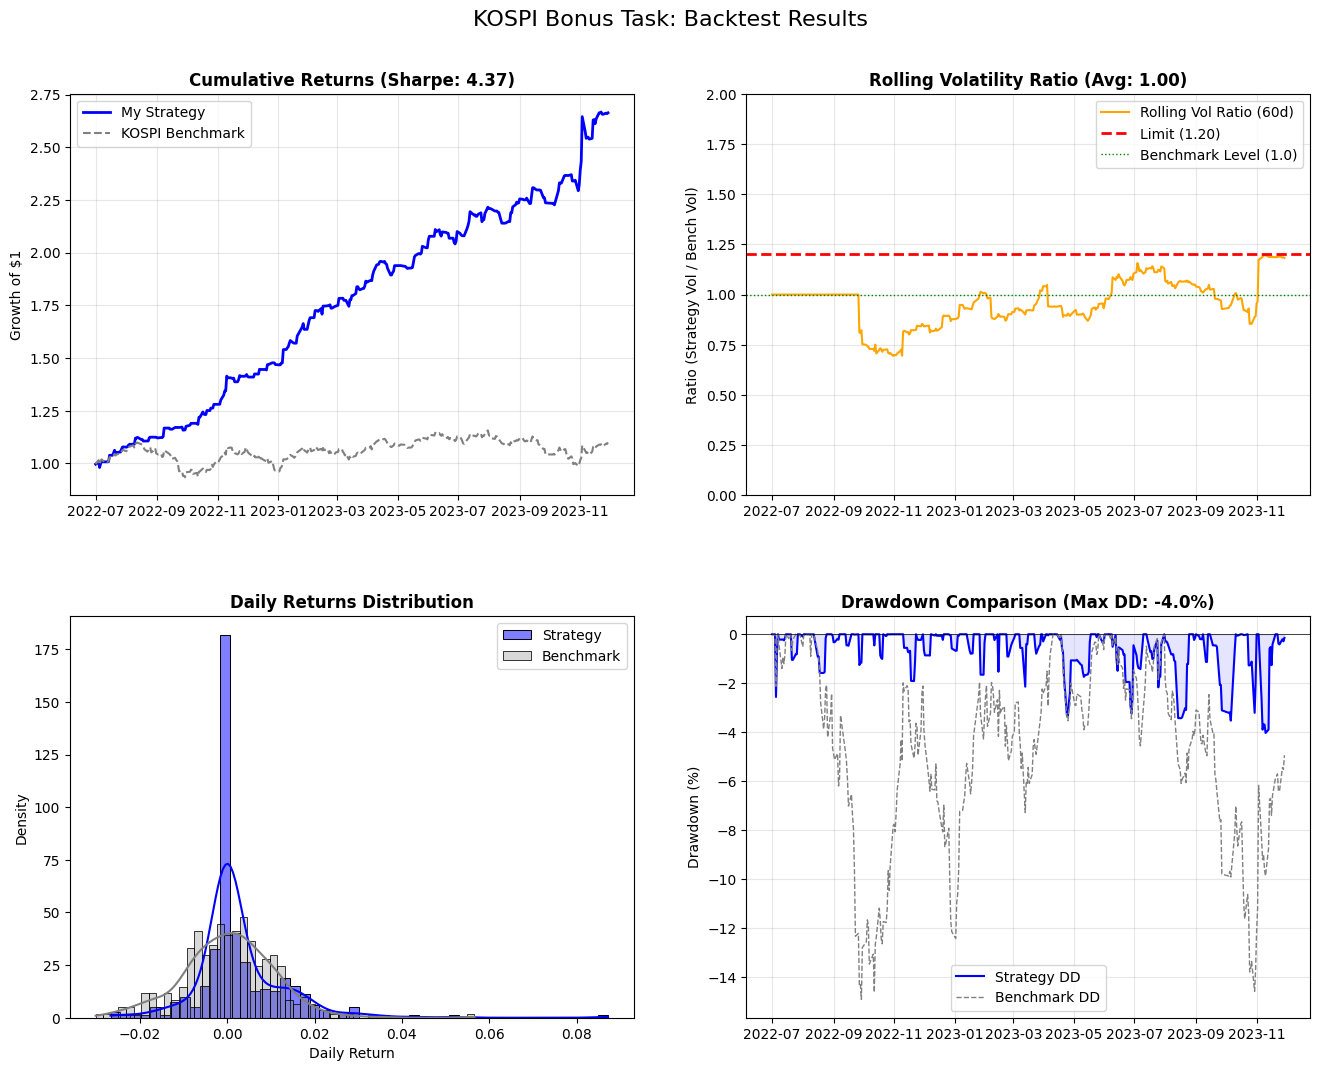

In [8]:
# --------------------------------------------------------------------------------
# 6. Advanced Evaluation & Visualization
# --------------------------------------------------------------------------------

# 1. Prepare Data
results_df = pd.DataFrame(results)
results_df['Strategy_Return'] = results_df['Weight'] * results_df['Actual_Return']
results_df['Date'] = pd.to_datetime(results_df['Date'])
results_df.set_index('Date', inplace=True)

# 2. Define Metrics Calculation Functions
def calculate_sharpe(returns):
    if returns.std() == 0: return 0
    return (returns.mean() / returns.std()) * np.sqrt(252)

def calculate_drawdown(cum_returns):
    roll_max = cum_returns.cummax()
    drawdown = (cum_returns - roll_max) / roll_max
    return drawdown * 100  # 퍼센트 단위

# 3. Calculate Metrics
strat_sharpe = calculate_sharpe(results_df['Strategy_Return'])
bench_sharpe = calculate_sharpe(results_df['Actual_Return'])

cum_strategy = (1 + results_df['Strategy_Return']).cumprod()
cum_benchmark = (1 + results_df['Actual_Return']).cumprod()

dd_strategy = calculate_drawdown(cum_strategy)
dd_benchmark = calculate_drawdown(cum_benchmark)

roll_vol_strat = results_df['Strategy_Return'].rolling(window=60).std()
roll_vol_bench = results_df['Actual_Return'].rolling(window=60).std()
roll_vol_ratio = roll_vol_strat / roll_vol_bench
roll_vol_ratio = roll_vol_ratio.fillna(1.0)

total_vol_strat = results_df['Strategy_Return'].std()
total_vol_bench = results_df['Actual_Return'].std()
avg_vol_ratio = total_vol_strat / total_vol_bench


# 4. Print Summary Text
print("="*50)
print("             Final Backtest Summary")
print("="*50)
print(f"Strategy Sharpe Ratio  : {strat_sharpe:.4f}")
print(f"Benchmark Sharpe Ratio : {bench_sharpe:.4f}")
print("-" * 50)
print(f"Total Volatility Ratio : {avg_vol_ratio:.4f} (Limit: ≤ 1.20)")
print(f"Max Drawdown (Strategy): {dd_strategy.min():.2f}%")
print(f"Max Drawdown (Bench)   : {dd_benchmark.min():.2f}%")
print("="*50)

# 5. Dashboard Visualization (4 Plots)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(hspace=0.3)

# [Top-Left] Cumulative Returns
axes[0, 0].plot(cum_strategy, label='My Strategy', color='blue', linewidth=2)
axes[0, 0].plot(cum_benchmark, label='KOSPI Benchmark', color='gray', linestyle='--', linewidth=1.5)
axes[0, 0].set_title(f'Cumulative Returns (Sharpe: {strat_sharpe:.2f})', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_ylabel('Growth of $1')

# [Top-Right] Rolling Volatility Ratio
axes[0, 1].plot(roll_vol_ratio, color='orange', label='Rolling Vol Ratio (60d)')
axes[0, 1].axhline(y=1.20, color='red', linestyle='--', linewidth=2, label='Limit (1.20)')
axes[0, 1].axhline(y=1.00, color='green', linestyle=':', linewidth=1, label='Benchmark Level (1.0)')
axes[0, 1].set_title(f'Rolling Volatility Ratio (Avg: {avg_vol_ratio:.2f})', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].set_ylim(0, 2.0)  # 비율이므로 0~2 사이로 고정
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].fill_between(roll_vol_ratio.index, roll_vol_ratio, 1.20, where=(roll_vol_ratio > 1.20), color='red', alpha=0.3, interpolate=True)
axes[0, 1].set_ylabel('Ratio (Strategy Vol / Bench Vol)')

# [Bottom-Left] Daily Returns Distribution
sns.histplot(results_df['Strategy_Return'], bins=50, kde=True, ax=axes[1, 0], color='blue', alpha=0.5, label='Strategy', stat='density')
sns.histplot(results_df['Actual_Return'], bins=50, kde=True, ax=axes[1, 0], color='gray', alpha=0.3, label='Benchmark', stat='density')
axes[1, 0].set_title('Daily Returns Distribution', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].set_xlabel('Daily Return')

# [Bottom-Right] Drawdown Comparison
axes[1, 1].plot(dd_strategy, label='Strategy DD', color='blue', linewidth=1.5)
axes[1, 1].plot(dd_benchmark, label='Benchmark DD', color='gray', linestyle='--', linewidth=1)
axes[1, 1].fill_between(dd_strategy.index, dd_strategy, 0, color='blue', alpha=0.1)
axes[1, 1].set_title(f'Drawdown Comparison (Max DD: {dd_strategy.min():.1f}%)', fontsize=12, fontweight='bold')
axes[1, 1].axhline(y=0, color='black', linewidth=0.5)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylabel('Drawdown (%)')

plt.suptitle(f"KOSPI Bonus Task: Backtest Results", fontsize=16, y=0.95)
plt.savefig('kospi_backtest_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()